# How to renormalize the Schrödinger equation

## Introduction

In the following notebook I want to repeat the analysis of Lepage described in the paper https://arxiv.org/abs/nucl-th/9706029. The main idea is that we can apply the idea behind renormalization of field theories - low-energy approximation to arbitrary high-energy physics - even in the context of non-relativistic standard Schrödinger equation. The transformation from the real theory to a simpler effective theory is achieved in two steps. First we introduces a cutoff $\Lambda$ that is of order of the momentum at which unkown physics becomes important. Obviously we don't know the scale $\Lambda$ at which this happens but results are almost independent of $\Lambda$ provided it is much larger then the momenta in the range being probed experimentally. The second step is to add local interactions mimicking the effects of the true short-distance physics. The reason lies in the uncertainty principle: any state involving momentum larger then the cutoff is necessary highly virtual and must occur over distances of order $1/\Lambda$ or less. In principle there are infinitley manu correction term but, when whorking to a given precision, only a finite number of them are important.
At the end only it is only the numerical values of the couplings that contain information about the short-range physics.
Before illustrating the construction and use of an effective theory that reproduces a given collection of low-energy data, I discuss the data which are generated inventing a physical system and solving the Schrödinger equation that describes it.

## Synthetic data solving Schrödinger equation
For the system we can consider the familiar one-particle Coulombic atom, but with a short-range potentiale $V_S(r)$ in addition to the Coulomb potential:
$$
H = \frac{\textbf{p}^2}{2m} + V(r)
$$
where
$$
V(r) = - \frac{Zq_e^2}{r} + V_S(r).
$$
For our purposes the form of $V_S(r)$ is irrelevant, without any particular reason I chose
$$
V_S(r) = b_0 \frac{e^{- r / b_1}}{r},
$$
where $b_0, b_1$ are parameters determining the precise form of the potential. I set $b_0 = -q_e^2$ and $b_1 = a_0$. Once we have the potential we can solve the radial Schrödinger equation
$$
-\frac{\hbar}{2m} \frac{d^2 \chi}{dr^2} + \left[V(r) + \frac{\hbar^2 l (l +1)}{2mr^2} - E \right] \chi(r) = 0
$$
To solve numerically this equation I used Numerov's method.

### Numerov's method
Numerov's method (after the Russian astronomer Boris Vasilyevich Numerov) is useful to integrate second-order differential equations of the general form
$$
\frac{d^2 y}{dx^2} = - g(x) y(x) + s(x).
$$
Taylor expanding $y(x)$ backward and forward up to fifth order and then taking the sum we get
$$
y_{n+1} + y_{n_1} = 2y_n + y_n^"(\Delta x)^2 + \frac{1}{12}y_n^{""}(\Delta x)^4 + \mathcal{O}[(\Delta x)^6]
$$
One can define $y_n^" \coloneqq z_n$, and repeat Taylor expanding as above to obtain
$$
y_n^{""} = z_n^" = \frac{z_{n+1} + z_{n-1} - 2z_n}{(\Delta x)^2} + \mathcal{O}[(\Delta x)^2].
$$
We can substitute above and obtain the $\text{\emph{Numerov's formula}}$
$$
y_{n+1}\left[1 + g_{n+1} \frac{(\Delta x)^2}{12}\right] = 2y_n \left [1 - 5g_n \frac{(\Delta x)^2}{12} \right] - y_{n-1}\left[1 + g_{n-1} \frac{(\Delta x)^2}{12}\right] + (s_{n +1} +10 s_n + s_{n -1})\frac{(\Delta x)^2}{12} + \mathcal{O}[(\Delta x)^6]
$$
In the case of Schrödigner equation $s-$terms are absent and it it convenient to define $f_n \coloneqq 1 + g_n (\Delta x)^2 / 12$ and rewrite
$$
y_{n+1} = \frac{(12-10f_n)y_n + f_{n-1}y_{n-1}}{f_{n+1}}.
$$
To avoid the problem of divergence at large x the matching method is implemented, so actually two integrations are performed: a forward recursion starting from $0$ and a backward one starting from $x_{\text{max}}$. The matching point is chosen in correspondence of the classical inversion point $x_{\text{cl}}$, i.e. where $V(x_{\text{cl}})$. Before starting the analysis we need to notice another critical aspect of trying to solve straightforwardly the radial equation: the singularity of the potential at $r = 0$.

### Logarithmic grid
One way to avoide the problem of singularity is to work with a variable-step grid instead of a constant-step one. We can introduce a variable $x$ and a constant-step grid in $x$ sp that we are able to use Numerov's method without changes. Then we define a mapping between $r$ and $x$
$$
x(r) = \text{log}\frac{Zr}{a_0}
$$
where $a_0$ is the Bohr radius. This choice yields
$$
\Delta x = \frac{\Delta r}{r},
$$
the ratio $\Delta r / r$ remains constant on the grid of $r$, called $\text{\emph{logarithmic gric}}$. Unfortunately transforming the radial equation using variable $x$ a term with the first derivative appears preventing the usage of Numerov's. This can be solved by the following transformation
$$
y(x) = \frac{1}{\sqrt{r}}\chi(r(x)),
$$
substituting and multiplying by $r^{3/2}$ we get
$$
\frac{d^2 y}{dx^2} + \left[ \frac{2m_e}{\hbar^2} r^2 (E - V(r)) - \left(l + \frac{1}{2}\right)^2\right]y(x) = 0
$$
which is solvable by Numerov with
$$
g(x) = \frac{2m_e}{\hbar^2}r(x)^2 (E-V(r)) - \left( l + \frac{1}{2} \right)^2.
$$
It is practical to work with $\text{\emph{atomic units}}$ (a.u.): units of length will be expressend in Bohr radii $a_0$:
$$
a_0 = \frac{\hbar^2}{m_e q_e^2} = 0.529177 \times 10^{-10} \text{m},
$$
while energies are expressed in $\text{\emph{Rydberg}}$ (Ry):
$$
1 \text{Ry} = \frac{m_e q_e^4}{2 \hbar^2} = 13.6058 \text{eV}.
$$
In such units we have $\hbar = 1$, $m_e = 1/2$ and $q_e^2 = 2$.
Creation of the logarithmic gris is the starting point of our program, this is done by the function "prepare_grid" which defines once and for all the values of $r$, $\sqrt{r}$, $r^2$ for each grid point. We have

In [43]:
#Radial Schrodinger equation using Numerov method

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from scipy.special import erf
from scipy.optimize import minimize

def prepare_grid(n_points, x_min, dx):

    #preparing x-array with constant step
    x = np.linspace(x_min, x_min + ((n_points - 1) * dx), n_points)
    x = np.append(x, x[n_points - 1] + dx) #another point for convenience of indices

    #generate r, sqrt_r, and r^2 based on logarithmic x grid
    r = np.exp(x)
    sqrt_r = np.sqrt(r)
    r2 = np.power(r, 2)

    #print grid information
    print("Radial grid information:\n")
    print("dx = ", dx)
    print("x_min = ", x_min)
    print("n_points = ", n_points)
    print("r(0) = ", r[0])
    print("r(n_points) = ", r[n_points])
    print("-----------------------------------------------\n")

    return r, sqrt_r, r2

### Potential
To set the potential we will use the function "init_potential" which has another suffix to specify the specific potential, i.e. "init_potential_coulomb".
We will consider first the simple Coulomb potential to test the code and the we will consider the short-range term.

In [44]:
def init_potential_coulomb(r):

    #definition of the potential
    v_pot = -2/r #Z=1, (Rydberg) atomic units

    #saving the potential to CSV
    df_pot = pd.DataFrame({"r": r, "V(r)": v_pot})
    df_pot.to_csv("potentials/coulomb_potential.csv", index=False)
    print("potential saved in 'potentials/coulomb_potential.csv'\n")

    
    #plotting the potential
    plt.figure()
    plt.plot (r, v_pot, label=r'V(r), atomic units (Ry)', color ='b')
    plt.xlabel("r")
    plt.ylabel("V(r)")
    plt.title("coulomb potential")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 0.01)
    plt.savefig("potentials/coulomb_potential_plot.pdf")
    plt.close()
    
    return v_pot

def init_potential_short(r):

    #definition of the potential
    v_pot = -2/r - (2 * np.exp(-r)) / r 

    #saving the potential to CSV
    df_pot = pd.DataFrame({"r": r, "V(r)": v_pot})
    df_pot.to_csv("potentials/short_potential.csv", index=False)
    print("potential saved in 'potentials/short_potential.csv'\n")

    
    #plotting the potential
    plt.figure()
    plt.plot (r, v_pot, label=r'V(r), atomic units (Ry)', color ='b')
    plt.xlabel("r")
    plt.ylabel("V(r)")
    plt.title("potential with short range term")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 0.01)
    plt.savefig("potentials/short_potential_plot.pdf")
    plt.close()

    return v_pot

### "solve_schrodinger" function
The function "solve_schrodinger" is the main function of the program. It solves numerically the schrödinger equation using Numerov's method, it returns the eigenvalue, the eigenfunction and the phase shift of the eigenfunction computed at $r=100$. An explanation is necessary for the convergence of the eigenvalue: it is implemented using a reasoning based on perturbation theory.
At the classical inversion point the first derivative of the function $y$ will be in general discontinuous unless we have reached a good eigenvalue. We can consider this function as the exact function respect to a different problem, one in which a delta function at the classical inversion point is superimposed to the potential. The discontinuity is related to the coefficient of this delta function, and once this is known one can give an estimate of the difference between the current eigenvalue and the one of the "true" potential. Performing the computation we get
$$
\delta e = |y(x_{cl})|^2 r(x_{cl})^2 \delta V \Delta x = - \frac{\hbar^2}{2m_e} \frac{12}{(\Delta x)^2} |y(x_{cl})|^2 \Delta x \delta f.
$$

In [45]:
def solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n, l):
    #solve the radial schrodinger equation on a logarithmic
    #grid by Numerov method - atomic units (Ry)

    eps = 1E-10 #tolerance for eigenvalue
    n_iter = 200

    #useful quantities
    ddx12 = (dx * dx) / 12
    sqlhf = (l + 0.5) * (l + 0.5) #
    x2l2 = 2 * l + 2
    
    #initial lower and upper bounds to the eigenvalue
    #print("-----------------------------------------------\n")
    e_upp = v_pot[n_points]
    e_low = e_upp

    for j in range(0, n_points + 1):
            e_low = np.minimum(e_low, sqlhf / r2[j] + v_pot[j])

    if (e_upp - e_low < eps):
        print("error in solving schrodinger: e_upp and e_low coincide", file = sys.stderr)
        sys.exit(1)
            
    e = (e_low + e_upp) * 0.5 #first rough estimate

    f = np.zeros(n_points + 1) #f-function for Numerov
    
    de = 1E10 #any number greater than eps
    
    class_inv = -1 #index of classical inversion point
    
    #start loop to find energy eigenvalue
    i = 0
    while i  < n_iter and np.absolute(de) > eps:
        #set up the f-function (in a way to determine the position of its last change of sign)

        f[0] = ddx12 * ((r2[0] * (v_pot[0] - e)) + sqlhf)
        for j in range(1, n_points + 1):
            f[j] = ddx12 * ((r2[j] * (v_pot[j] - e)) + sqlhf)

            #if f[j] is exactly zero (unlikely) the change of sign is not observed 
            #trick to prevent missing change of sign
            if (f[j] == 0.):
                f[j] = 1E-20

            #take the index of classical inversion
            if np.sign(f[j]) != np.sign(f[j - 1]):
                class_inv = j

        #if class_inv < 0 or class_inv >= n_points -2:
        #    print(f"{class_inv:4d} {n_points:4d} {n}")
        #    print("error in solving schrodinger: last change of sign too far", file = sys.stderr)
        #    sys.exit(1)

        #rewrite the f-function how required by numerov method
        f = 1 - f

        y = np.zeros(n_points + 1) #wavefunction
        nodes = n - l - 1
        
        #wavefunction in the first two points
        y[0] = 1E-10
        y[1] = 1E-5

        #outward integration with node counting
        n_cross = 0
        for j in range(1, class_inv):
            y[j + 1] = ((12. - f[j] * 10.) * y[j] - f[j - 1] * y[j - 1]) / f[j + 1]
            if np.sign(y[j]) != np.sign(y[j + 1]):
                n_cross += 1

        scale_factor = y[class_inv] #value of the wavefunction at classical turning point to match outward and inward
        
        #check the number of crossings
        if (n_cross != nodes):
            #incorrect number of nodes, adjusting eigenvalue
            if (n_cross > nodes):
                e_upp = e
            else:
                e_low = e

            e = (e_upp + e_low) * 0.5

        else:
            #correct number of nodes, we can perform inward integration.

            #determination of the wavefunction in last two points
            #assuming y[n_points + 1] = 0 and y[n_points] = dx
            y[n_points] = dx
            y[n_points - 1] = (12. - f[n_points] * 10.) * y[n_points] / f[n_points - 1]

            #inward integration
            for j in range(n_points - 1, class_inv, -1):
                y[j - 1] = ((12. - f[j] * 10.) * y[j] - f[j + 1] * y[j + 1]) / f[j - 1]
                if (y[j - 1] > 1E10):
                    for m in range(n_points, j - 2, -1):
                        y[m] /= y[j - 1]

            #rescale the function to match at the classical turning point
            scale_factor /= y[class_inv]
            for j in range(class_inv, n_points + 1):
                y[j] *= scale_factor


            #normalize on the segment
            norm = 0.

            for j in range(1, n_points + 1):
                norm += y[j] * y[j] * r2[j] * dx

            norm = np.sqrt(norm)

            for j in range(0, n_points + 1):
                y[j] /= norm

            #find the value of the cusp at the matching point
            j = class_inv
            y_cusp = (y[j - 1] * f[j - 1] + f[j + 1] * y[j + 1] + f[j] * 10. * y[j]) / 12.
            df_cusp = f[j] * (y[j] / y_cusp - 1.)

            # eigenvalue update using perturbation theory
            de = df_cusp / ddx12 * y_cusp * y_cusp * dx
            if (de > 0.):
                e_low = e
            if (de < 0.):
                e_upp = e

            e = e + de
            #prevent e to go out of bounds ( e > e_upp or e < e_low)
            #could happen far from convergence
            e = np.minimum(e, e_upp)
            e = np.maximum(e, e_low)

        i += 1
    
    #convergence not achived
    if (np.abs(de) > eps):
        if n_cross != nodes:
            print(f"n_cross={n_cross:4d} nodes={nodes:4d} class_inv={class_inv:4d} " 
                f"e={e:16.8e} e_low={e_low:16.8e} e_upp={e_upp:18.8e}", file=sys.stderr)
        else:
            print(f"e={e:16.8e} de={de:16.8e}", file=sys.stderr)

        print(f"solve_schrodinger not converged after {n_iter} iterations", file=sys.stderr)
        sys.exit(1)

    #convergence achived
    #print(f"convergence for n = {n} achived at iter # {i:4d}, de = {de:16.8e}, e = {e:16.8e}\n")

    #compute phase shift ar r=100
    i_100 = 1261 #index corresponding to r = 100
    phase_shift = np.arcsin(y[i_100]) - np.sqrt(np.absolute(e)) * r[i_100] + (l * np.pi)/2

    return e, y, phase_shift

### "analysis" function
Since we are going to repeat the same operations more times, it is convenient to define the following function which solves the Schrödinger equation for more eigenvalues and save the into csv and pdf files.

In [46]:
def analysis(n_max, pot_name, e_n, p_n, y_n, n_points, dx, v_pot, r2 , r, sqrt_r):
    #quantic numbers
    n=1
    l=0 #fixed, considering only s-wave

    for i in range(1, n_max +1):
        e_n[i-1], y_n[i-1], p_n[i-1] = solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n ,l)

        #saving and plotting eigenfunctions
        y_df = pd.DataFrame({"r": r, "y": y_n[i-1]})
        y_df.to_csv(f"eigenfunctions/eigenfunction_{pot_name}_{i}.csv", index=False)

        plt.figure()
        plt.plot(r, sqrt_r * y_n[i-1], label = r'$\chi$', color = 'red')
        plt.xlabel("r")
        plt.ylabel(r'$\chi(r)$')
        plt.title(f"{pot_name} wavefunction n = {i}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"eigenfunctions/{pot_name}_wavefunction_{i}.pdf")
        plt.close() #to save memory
        
        n += 1 #next energy level

    n_arr = np.arange(1, n_max + 1)

    #saving eigenvalues, phase shifts
    e_df = pd.DataFrame({"n": n_arr, "E": e_n})
    print("-----------------------------------------------\n")
    print(f"{pot_name} energy eigenvalues\n")
    print(e_df.to_markdown(index=False))
    e_df.to_csv(f"energy/energy_eigenvalues_{pot_name}.csv", index=False)

    p_df = pd.DataFrame({"n": n_arr, "phase shift": p_n})
    print("-----------------------------------------------\n")
    print(f"{pot_name} phase shifts at r = 100\n")
    print(p_df.to_markdown(index=False))
    p_df.to_csv(f"phase_shift/phase_shift_{pot_name}.csv", index=False)

    return e_n, y_n, p_n


## Coulomb test
To test the solve_schrodinger function I will consider the first simple case of the Coulomb potential. I also evaluated the relative error of the results with respect to the analytical value of the eigenvalues.

Radial grid information:

dx =  0.01
x_min =  -8.0
n_points =  1399
r(0) =  0.00033546262790251185
r(n_points) =  399.41460992710995
-----------------------------------------------

potential saved in 'potentials/coulomb_potential.csv'

-----------------------------------------------

coulomb energy eigenvalues

|   n |           E |
|----:|------------:|
|   1 | -0.998666   |
|   2 | -0.249833   |
|   3 | -0.111062   |
|   4 | -0.0624791  |
|   5 | -0.0399893  |
|   6 | -0.0277716  |
|   7 | -0.0204043  |
|   8 | -0.0156224  |
|   9 | -0.0123438  |
|  10 | -0.00999867 |
-----------------------------------------------

coulomb phase shifts at r = 100

|   n |   phase shift |
|----:|--------------:|
|   1 |     -100.417  |
|   2 |      -50.2253 |
|   3 |      -33.4873 |
|   4 |      -25.1168 |
|   5 |      -20.0941 |
|   6 |      -16.747  |
|   7 |      -14.3436 |
|   8 |      -12.5724 |
|   9 |      -11.1715 |
|  10 |      -10.0489 |


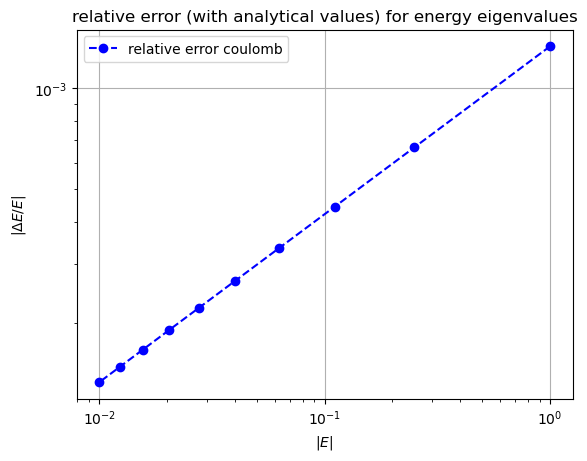

In [47]:
#grid parameters
r_max = 400
x_min = -8. #corresponds to r_min == 3 * 1E-4 Bohr radii
dx = 0.01 #grid spacing
n_max = 10 # maximum energy level (# of nodes limited by range)

#number of points of the grid
n_points = int((np.log(r_max) - x_min) / dx)

#initialize logarithmic grid
r, sqrt_r, r2 = prepare_grid(n_points, x_min, dx)

#initialize potential
v_pot_1 = init_potential_coulomb(r)
v_pot_1_name = "coulomb"

#initialize arrays for eigenvalues, eigenfunctions and phase shifts
e_coulomb = np.zeros(n_max)
y_coulomb = np.zeros((n_max, n_points + 1))
ph_shift_coulomb = np.zeros(n_max)

e_coulomb, y_coulomb, ph_shift_coulomb = analysis(n_max, v_pot_1_name, e_coulomb, ph_shift_coulomb, y_coulomb, n_points, dx, v_pot_1, r2 , r, sqrt_r)

#comparison with analytical values -1/n^2
e_theo = np.arange(1, n_max + 1)
e_theo = -1 / (e_theo ** 2)

plt.figure()
plt.plot(np.absolute(e_theo), np.absolute(e_coulomb - e_theo)/ np.absolute(e_theo) , marker = 'o', linestyle = '--', label = "relative error coulomb", color = 'blue')
plt.xlabel(r'$|E|$')
plt.ylabel(r'$|\Delta E / E|$')
plt.title(f"relative error (with analytical values) for energy eigenvalues")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.show()
plt.savefig(f"relative_errors/relative_error_coulomb_eigenvalues.pdf")
plt.close()

## Short range potential term
Now we will repeat the computation with the short range term. The results will be our synthetic data.

In [48]:
#initialize potential
v_pot_2 = init_potential_short(r)
v_pot_2_name = "short"

#initialize arrays for eigenvalues, eigenfunctions and phase shifts
e_short = np.zeros(n_max)
y_short = np.zeros((n_max, n_points + 1))
ph_shift_short = np.zeros(n_max)

e_short, y_short, ph_shift_short = analysis(n_max, v_pot_2_name, e_short, ph_shift_short, y_short, n_points, dx, v_pot_2, r2 , r, sqrt_r)


potential saved in 'potentials/short_potential.csv'

-----------------------------------------------

short energy eigenvalues

|   n |          E |
|----:|-----------:|
|   1 | -2.56484   |
|   2 | -0.36604   |
|   3 | -0.14061   |
|   4 | -0.0742453 |
|   5 | -0.0458276 |
|   6 | -0.031084  |
|   7 | -0.0224619 |
|   8 | -0.0169871 |
|   9 | -0.013295  |
|  10 | -0.0106879 |
-----------------------------------------------

short phase shifts at r = 100

|   n |   phase shift |
|----:|--------------:|
|   1 |     -160.927  |
|   2 |      -60.7941 |
|   3 |      -37.6796 |
|   4 |      -27.3799 |
|   5 |      -21.511  |
|   6 |      -17.7166 |
|   7 |      -15.0536 |
|   8 |      -13.1115 |
|   9 |      -11.5873 |
|  10 |      -10.3829 |


## Naive approximation
Our challenge is now to design a simple theory that reproduces low-energy data with high precision. A standard approach is to approximate the unknown short ranger potential by a delta function, whose effect is computed using first-order perturbation theory. The approximate hamiltonian is
$$
H_{app} = \frac{\textbf{p}^2}{2m} - \frac{Zq_e^2}{r} + c \,\delta^3 (\textbf{r})
$$
where $c$ is a parameter. Using first-order perturbation theory, the energy levels in our approximate theory are
$$
E_n^{app} = - \frac{1}{n^2} + c \frac{\delta_{l,0}}{\sqrt{\pi}n^3}.
$$
To determine the parameter $c$ we fit this formula to our lowest-energy data because it is the least sentive one to the replacement $V_S(r) \rightarrow c\, \delta^3(r)$. In our case the lowest-ergy data is the $14S$ binding energy.

In [49]:
#lowest-energy data is the one corresponing to n_max = 10
c = np.sqrt(np.pi) * (e_short[n_max - 1] * np.power(n_max, 3) + n_max)

print("c = ", c)

c =  -1.2192867207762426


Now I show the relative errors in $S$-wave binding energies, plotted versus the binding energies, obtained using just a Coulomb potential ($c = 0$) and using the approximate formula above.

-1.6879088672200577


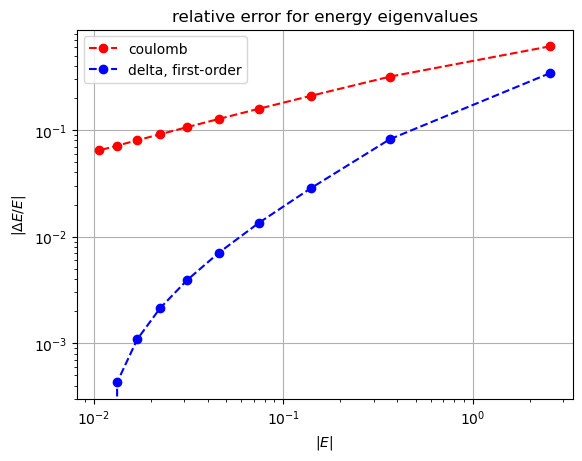

In [50]:
#coulomb eigenvalues in e_theo

#approximate eigenvalues
e_app = np.arange(1,n_max + 1)
e_app = - 1/ np.power(e_app, 2) + c / (np.sqrt(np.pi) * np.power(e_app, 3))
print(e_app[0])

#plotting relative errors
plt.figure()
plt.plot(np.absolute(e_short), np.absolute(e_short - e_theo)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = "coulomb", color = 'red')
plt.plot(np.absolute(e_short), np.absolute(e_short - e_app)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = "delta, first-order", color = 'blue')
plt.xlabel(r'$|E|$')
plt.ylabel(r'$|\Delta E / E|$')
plt.xscale("log")
plt.yscale("log")
plt.title(f"relative error for energy eigenvalues")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(f"relative_errors/relative_error_naive_approx_eigenvalues.pdf")
plt.close()

Both approximations become more accurate as the binding energy decreases, but adding the delta function in first order gives better results. However, the limitations of this approximation become evident if we consider the second-order contribution to $E_n^{app}$, this gives in fact an infinite shift due to the sum over scattering eigenstates which diverges as $p \rightarrow \infty$. The delta function is too singular to be meaningful beyond first-order perturbation theory.

## Effective theory

The infinities in the previous section are exactly analogous to those found in quantum field theories. They indicate that even low-energy processes are sensitive to physics at short distances. Renormalization theory tells us that the low-energy behavior of the theory is however independent from the shrot-distance details. this means that we can generally replace the short-distance dynamics of a theory without changing the low energy behavior. This allow us to create an effective theory to model low-energy datasets with arbitrary precision. We follow these 3 steps:
1. Incorporate the correct long-range behavior
2. Introduce an ultraviolet cutoff to exclude high momentum states which are sensitive to short-distance physics. At the same time this cutoff will regularize infinities.
3. Add local correction terms to the effective hamiltonian to mimik the effects of high-momentum states excluded in 2. Each correction term isformes by a theory-specific coupling constant times a theory-independent local operator.

To begin, our effective theory is specified by
$$
H_{eff} = \frac{\textbf{p}^2}{2m} + V_{eff}(r)
$$
where $V_{eff}$ must become Coulombic at large r. We can introduce the cutoff a through its Fourier transform
$$
\frac{1}{r} \xrightarrow{F.T.} \frac{4\pi}{k^2} \xrightarrow{cutoff} \frac{4\pi}{k^2}e^{-k^2a^2/2} \xrightarrow{F.T.} \frac{\text{erf}(r/\sqrt{2}a)}{r}
$$
where
$$
\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}\, dt
$$
is the standard error function. The exact form of the cutoff is irrelevant. This potential inhibits momentum transfers of order $\Lambda \coloneqq 1/a$. To mimic the effects of the true chort-distance structure we use local correction termswhich are polynomial in the momentum operator multiplied by a delta function. We use the UV cutoff to smear the delta functions:
$$
\delta^3_a(\textbf{r})\coloneqq \frac{e^{-r^2/2a^2}}{(2\pi)^{3/2}a^3},
$$
even in this case the detailed structure is irrelevant; other chioces work just as well. The effective potential must have the form
$$
V_{eff}(\textbf{r})= -\frac{Z q_e^2}{r}\text{erf}(r/\sqrt{2}a) + c a^2 \delta^3_a (\textbf{r}) + d_1 a^4 \nabla^2 \delta^3_a (\textbf{r}) + \dots + g a^{n+2} \nabla^n \delta^3_a(\textbf{r}) + \dots
$$
While the theory is obviously independent of the value of the cutoff $a$, the results computed in the effective theory are only approximately $a$ independent. Usually residual dependence comes in power series $ka$ where $k$ is the characteristic momentum associated with a process. Contact terms remove these $a$-dependent errors order-by-order in $a$. Only a finite number of contact terms is needed to remove errors through any finite order in $a$.
To choose the order of $a$ is necessary to consider the fact that it makes little sense to reduce $a$ below the range $r_s$ of the true short-range potential. When $a < r_s$ high-momentum states are included that are sensitive to structure at distances amller than $r_s$.

### Tuning the Effective Theory
We now tune the parameters of the effective theory so that it reproduces our low energy data through order $a^2$, considering only the term proportional to $c$ in $V_{eff}$, and through order $a^4$ keeping also the $d_1$ term, we dropped the $d_2$ term that is present only for $l > 0$ (we consider $S$-waves). First let's define out function "init_potential" for the case of an effective theory

In [51]:
def init_potential_effective(r, a, c, d_1):

    #definition of the potential
    v_pot = -2/r * erf(r / (np.sqrt(2) * a)) + c * np.power(a,2) * np.exp(-np.power(r,2) / (2 * np.power(a,2))) / (np.power(2 * np.pi, 1.5) * np.power(a,3)) + d_1 * np.power(a,4) * ((np.power(r,2) / np.power(a,2)) - 3) * np.exp(-np.power(r,2) / (2 * np.power(a,2))) / (np.power(2 * np.pi, 1.5) * np.power(a,5)) 

    #saving the potential to CSV
    df_pot = pd.DataFrame({"r": r, "V(r)": v_pot})
    if d_1 == 0:
        df_pot.to_csv(f"potentials/effective_potential_a2_cut{a}.csv", index=False)
    else:
        df_pot.to_csv(f"potentials/effective_potential_a4_cut{a}.csv", index=False)
    
    #plotting the potential
    plt.figure()
    plt.plot (r, v_pot, label=r'V(r), atomic units (Ry)', color ='b')
    plt.xlabel("r")
    plt.ylabel("V(r)")
    plt.title("effective potential")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 0.01)
    if d_1 == 0:
        plt.savefig(f"potentials/effective_potential_a2_cut{a}_plot.pdf")
    else:
        plt.savefig(f"potentials/effective_potential_a4_cut{a}_plot.pdf")
    plt.close()

    return v_pot

The tuning of the parameters is performed considering different values for the cutoff $a$, in particular tha considered values are $a = 1,2,6,10$.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 95
         Function evaluations: 186
----------------------|a = 1|----------------------

(a^2 theory):    c = [-86.51509718] 

(a^4 theory): c = -90.93957878337021, d_1 = -3.13360336733036

-----------------------------------------------

effective_a^2_1 energy eigenvalues

|   n |          E |
|----:|-----------:|
|   1 | -2.83781   |
|   2 | -0.36576   |
|   3 | -0.140718  |
|   4 | -0.0742696 |
|   5 | -0.0458345 |
|   6 | -0.0310863 |
|   7 | -0.0224627 |
|   8 | -0.0169874 |
|   9 | -0.0132951 |
|  10 | -0.0106879 |
-----------------------------------------------

effective_a^2_1 phase shifts at r = 100

|   n |   phase shift |
|----:|--------------:|
|   1 |     -169.274  |
|   2 |      -60.7709 |
|   3 |      -37.694  |
|   4 |      -27.3844 

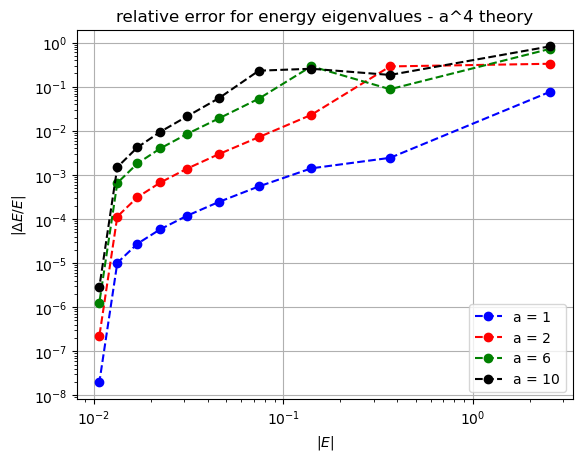

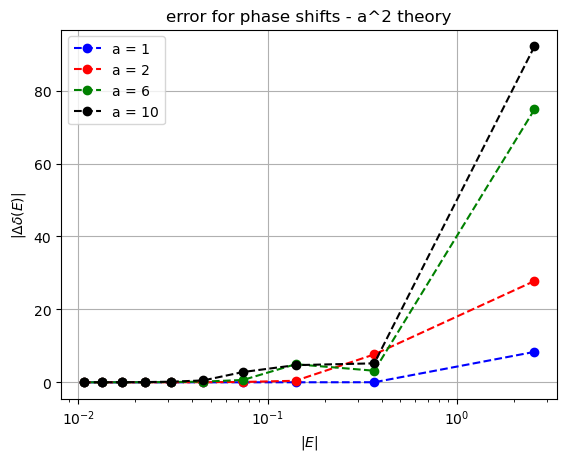

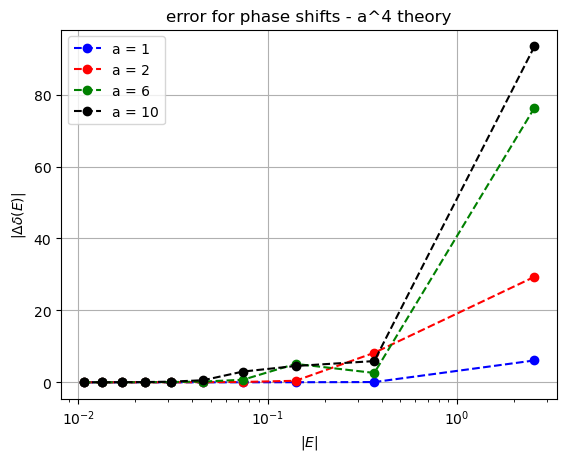

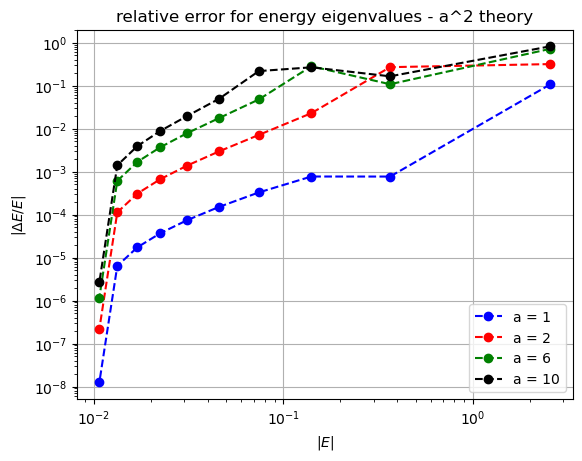

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [52]:
a = [1,2,6,10] #cutoff

#tuning of the parameter (lowest energy data - phase shift)
c_a2 = -50 # initial guess of the parameter a2

#initial guess of parameters
init_parameters = [-60, -1] #[c, d_1] a4

#cost function a2
def cost_function_1(c, a, n_points, dx, r2, r, sqtr_r, n_max):
    v_pot = init_potential_effective(r, a, c, 0)
    e, y, phase_shift = solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n_max, 0)
    return np.absolute(ph_shift_short[-1] - phase_shift)
    
#cost function a4
def cost_function_2(parameters, a, n_points, dx, r2, r, sqtr_r, n_max):
    c = parameters[0]
    d_1 = parameters[1]
    v_pot = init_potential_effective(r, a, c, d_1)
    e, y, phase_shift = solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n_max, 0)
    return np.absolute(ph_shift_short[-1] - phase_shift)
    
plt.figure(1)
plt.figure(2)
plt.figure(3)
plt.figure(4)
colors =['blue', 'red', 'green', 'black']

#later we want to use again results for a=1
e_eff_a2_cut1 = np.zeros(n_max)
e_eff_a4_cut1 = np.zeros(n_max)

for a_value, color in zip(a, colors):
    #compute parameter
    result1 = minimize(cost_function_1, c_a2, method='nelder-mead', args=(a_value, n_points, dx, r2, r, sqrt_r, n_max), options={'maxiter': 10000,'maxfev': 10000,'xatol': 1E-8, 'disp': True})
    result2 = minimize(cost_function_2, init_parameters, method='nelder-mead', args=(a_value, n_points, dx, r2, r, sqrt_r, n_max), options={'maxiter': 10000,'maxfev': 10000,'xatol': 1E-8, 'disp': True})

    c_a2 = result1.x
    parameters_a4 = result2.x
    c_a4 = parameters_a4[0]
    d_1 = parameters_a4[1]
    print(f"----------------------|a = {a_value}|----------------------\n")
    print(f"(a^2 theory):    c = {c_a2} \n")
    print(f"(a^4 theory): c = {c_a4}, d_1 = {d_1}\n")

    #initialize potential
    v_pot_3 = init_potential_effective(r, a_value, c_a2, 0)
    v_pot_3_name = f"effective_a^2_{a_value}"
    v_pot_4 = init_potential_effective(r, a_value, c_a4, d_1)
    v_pot_4_name = f"effective_a^4_{a_value}"

    #initialize arrays for eigenvalues, eigenfunctions and phase shifts
    e_eff_a2 = np.zeros(n_max)
    y_eff_a2 = np.zeros((n_max, n_points + 1))
    ph_shift_eff_a2 = np.zeros(n_max)
    e_eff_a4 = np.zeros(n_max)
    y_eff_a4 = np.zeros((n_max, n_points + 1))
    ph_shift_eff_a4 = np.zeros(n_max)

    e_eff_a2, y_eff_a2, ph_shift_eff_a2 = analysis(n_max, v_pot_3_name, e_eff_a2, ph_shift_eff_a2, y_eff_a2, n_points, dx, v_pot_3, r2 , r, sqrt_r)
    e_eff_a4, y_eff_a4, ph_shift_eff_a4 = analysis(n_max, v_pot_4_name, e_eff_a4, ph_shift_eff_a4, y_eff_a4, n_points, dx, v_pot_4, r2 , r, sqrt_r)

    #out of this scope we want to use again results for a=1
    if a_value == 1:
        e_eff_a2_cut1 = e_eff_a2
        e_eff_a4_cut1 = e_eff_a4
        
    #plotting relative errors for phase shifts and enrgies
    #energy
    plt.figure(1)
    plt.plot(np.absolute(e_short), np.absolute(e_short - e_eff_a2)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"a = {a_value}", color = color)
    plt.xlabel(r'$|E|$')
    plt.ylabel(r'$|\Delta E / E|$')
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"relative error for energy eigenvalues - a^2 theory")
    plt.legend()
    plt.grid(True)
    if a_value == 10:
        plt.show()
        plt.savefig(f"relative_errors/relative_error_energy_a2.pdf")
        plt.close(1)

    plt.figure(2)
    plt.plot(np.absolute(e_short), np.absolute(e_short - e_eff_a4)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"a = {a_value}", color = color)
    plt.xlabel(r'$|E|$')
    plt.ylabel(r'$|\Delta E / E|$')
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"relative error for energy eigenvalues - a^4 theory")
    plt.legend()
    plt.grid(True)
    if a_value == 10:
        plt.show()
        plt.savefig(f"relative_errors/relative_error_energy_a4.pdf"
        plt.close(2)
    
    #phase_shift
    plt.figure(3)
    plt.plot(np.absolute(e_short), np.absolute(ph_shift_short - ph_shift_eff_a2) , marker = 'o', linestyle = '--', label = f"a = {a_value}", color = color)
    plt.xlabel(r'$|E|$')
    plt.ylabel(r'$|\Delta \delta(E)|$')
    plt.xscale("log")
    plt.title(f"error for phase shifts - a^2 theory")
    plt.legend()
    plt.grid(True)
    if a_value == 10:
        plt.show()
        plt.savefig(f"relative_errors/relative_error_ph_shift_a2.pdf")
        plt.close(3)

    plt.figure(4)
    plt.plot(np.absolute(e_short), np.absolute(ph_shift_short - ph_shift_eff_a4) , marker = 'o', linestyle = '--', label = f"a = {a_value}", color = color)
    plt.xlabel(r'$|E|$')
    plt.ylabel(r'$|\Delta \delta(E)|$')
    plt.xscale("log")
    plt.title(f"error for phase shifts - a^4 theory")
    plt.legend()
    plt.grid(True)
    if a_value == 10:
        plt.show()
        plt.savefig(f"relative_errors/relative_error_ph_shift_a4.pdf")
        plt.close(4)        

## Conclusions
I want to conclude this analysis showing how the effective theory is the most accurate one to describe our set of data. I show the relative errors resulting from the different models:
- Coulomb theory
- Coulmob theory with perturbation theory (term proportional to delta)
- $a^2$-theory ($a=1$)
- $a^4$-theory ($a=1$)

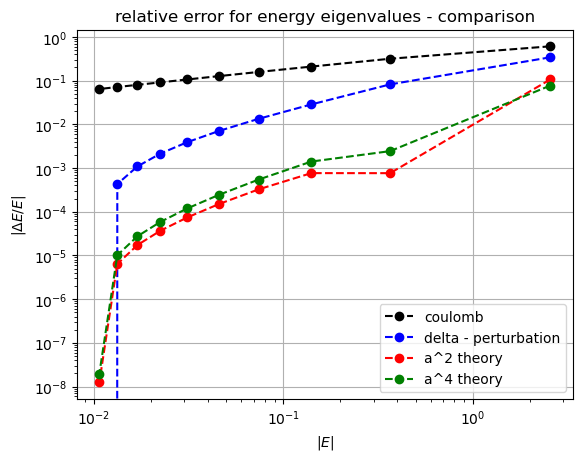

In [53]:
plt.figure()
plt.plot(np.absolute(e_short), np.absolute(e_short - e_theo)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"coulomb", color = 'black')
plt.plot(np.absolute(e_short), np.absolute(e_short - e_app)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"delta - perturbation", color = 'blue')
plt.plot(np.absolute(e_short), np.absolute(e_short - e_eff_a2_cut1)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"a^2 theory", color = 'red')
plt.plot(np.absolute(e_short), np.absolute(e_short - e_eff_a4_cut1)/ np.absolute(e_short) , marker = 'o', linestyle = '--', label = f"a^4 theory", color = 'green')
plt.xlabel(r'$|E|$')
plt.ylabel(r'$|\Delta E / E|$')
plt.xscale("log")
plt.yscale("log")
plt.title(f"relative error for energy eigenvalues - comparison")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(f"relative_errors/relative_error_energy_comparison.pdf")
plt.close()

## References

- Lecture notes - Numerical Methods in Quantum Mechanics - Paolo Giannozzi
- How to renormalize the Schrödinger equation - Peter Lepage - 1997 - https://arxiv.org/abs/nucl-th/9706029
- Computational Quantum Mechanics - Joshua Izaac, Jingbo Wang - https://link.springer.com/book/10.1007/978-3-319-99930-2